# Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer

# Import data

In [2]:
data = pd.read_csv("spam.csv",encoding='latin1')
data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# Drop unwanted columns

In [3]:
data.drop(columns = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"], inplace = True)
data.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Rename columns

In [4]:
data.rename(columns = {"v1":'result', 'v2':'emails'}, inplace = True)

# Returns number of NaN values in columns

In [5]:
data.isnull().sum()

result    0
emails    0
dtype: int64

# Returns number of duplicates

In [6]:
data.duplicated().sum()

403

# Drops duplicates keeping first occurences

In [7]:
data = data.drop_duplicates(keep='first')

In [8]:
data.shape

(5169, 2)

In [9]:
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Number of spam/ham emails

In [10]:
data['result'].value_counts()

result
ham     4516
spam     653
Name: count, dtype: int64

# Pie-chart

([<matplotlib.patches.Wedge at 0x26e955e4760>,
 [Text(-1.0144997251399075, 0.4251944351600247, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001344, '87.4%'),
  Text(0.5533635081542612, -0.23192418555038377, '12.6%')])

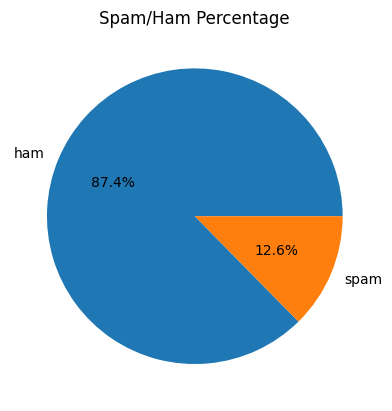

In [11]:
plt.title('Spam/Ham Percentage')
plt.pie(data['result'].value_counts(),labels = data['result'].value_counts().index, autopct='%1.1f%%')

# EDA (email length, no. of words, sentences)

In [12]:
data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)

,result,emails,Length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2


In [13]:
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
avg_sent_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sent_ham = data[data['result'] == 'ham']['num_sentence'].mean()

# Bar-graphs (avg length, word, sentences)

Average Length of Spam Emails: 137.89127105666157
Average Length of Ham Emails: 70.45925597874225


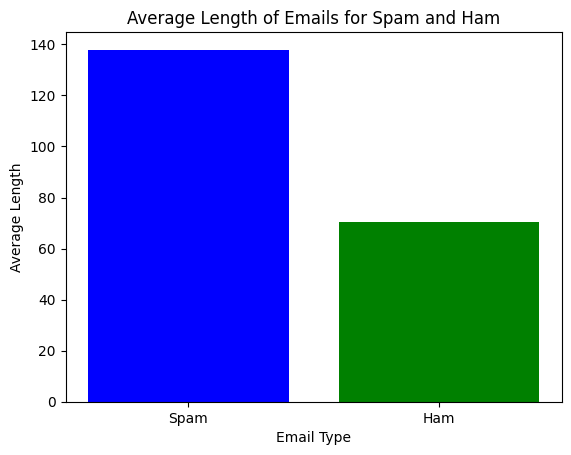

In [14]:
#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

Average Word of Spam Emails: 27.6676875957121
Average Word of Ham Emails: 17.12378210806023


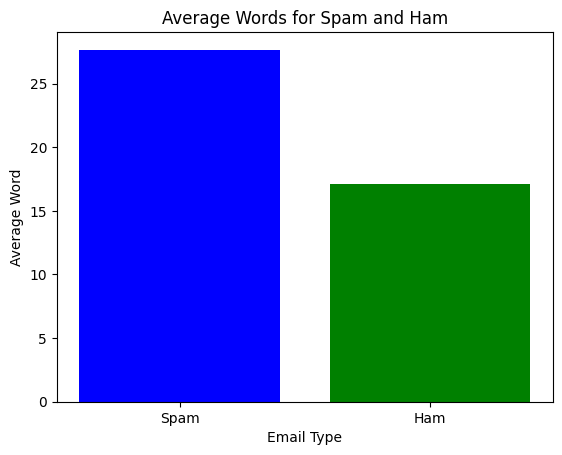

In [15]:
print("Average Word of Spam Emails:", avg_word_spam)
print("Average Word of Ham Emails:", avg_word_ham)
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['blue', 'green'])
plt.title('Average Words for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Word')
plt.show()

Average Sentences of Spam Emails: 2.970903522205207
Average Sentences of Ham Emails: 1.8201948627103632


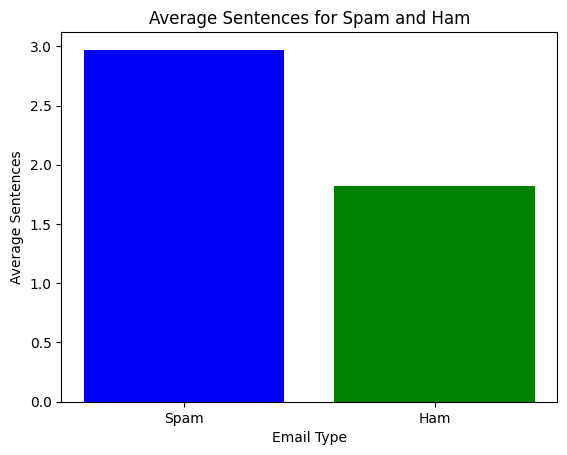

In [16]:
print("Average Sentences of Spam Emails:", avg_sent_spam)
print("Average Sentences of Ham Emails:", avg_sent_ham)
plt.bar(['Spam', 'Ham'], [avg_sent_spam, avg_sent_ham], color=['blue', 'green'])
plt.title('Average Sentences for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentences')
plt.show()

# Correlation between length and spam

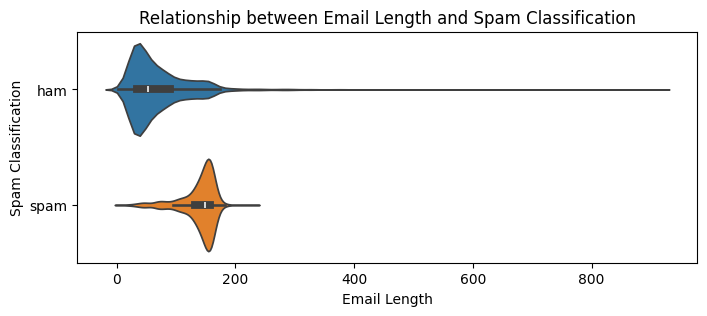

In [17]:
correlation = data['Length'].corr((data['result']=='spam').astype(int))
plt.figure(figsize=(8,3))
sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

# Relationship between features

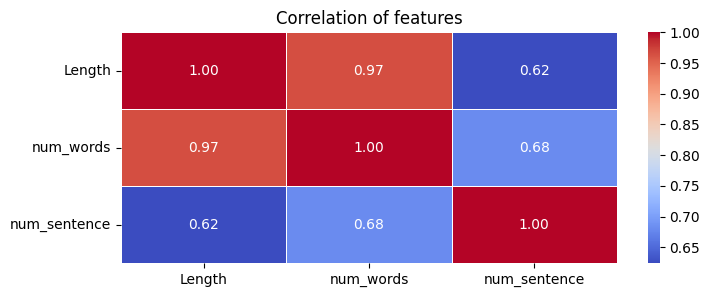

In [18]:
corr_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
plt.figure(figsize=(8,3))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=.5, cmap='coolwarm')
plt.title("Correlation of features")
plt.show()

# Data preprocessing

In [19]:
data['transform'] = data['emails'].str.lower() #lower case
data['transform'] = data['transform'].apply(word_tokenize) #word tokenization
data['transform'] = data['transform'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9/s]','',word) for word in x]) #remove special characters
stop_words = set(stopwords.words('english'))
data['transform'] = data['transform'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])
lemma = WordNetLemmatizer()
data['transform'] = data['transform'].apply(lambda x: [lemma.lemmatize(word) for word in x])
# ps = PorterStemmer()
# data['transform'] = data['transform'].apply(lambda x: [ps.stem(word) for word in x])
data['transform'] = data['transform'].apply(lambda x: ' '.join(x))
data[['emails', 'transform']].head()

,emails,transform
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah nt think go usf life around though


# Most Common Words in Spam

call: 302 times
free: 159 times
2: 156 times
txt: 128 times
u: 122 times
text: 117 times
mobile: 106 times
ur: 101 times
4: 99 times
claim: 97 times


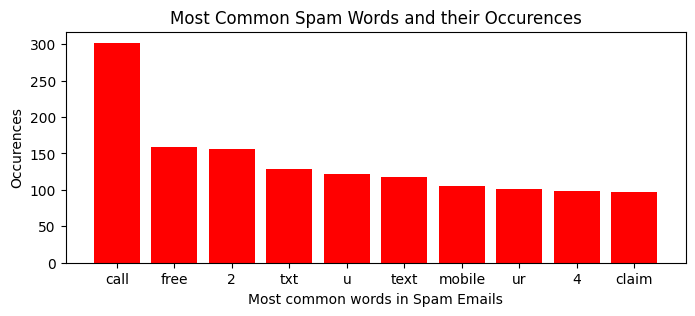

In [20]:
spam_emails = data[data['result']=='spam']['transform']
spam_words = ''.join(spam_emails).split()
word_counts = Counter(spam_words)
most_common_words = word_counts.most_common(10)
for word, count in most_common_words:
    print(f'{word}: {count} times')
get_words = lambda x: [word[0] for word in x]
get_occurences = lambda x: [word[1] for word in x]
words = get_words(most_common_words)
occurences = get_occurences(most_common_words)
plt.figure(figsize = (8,3))
plt.bar(words, occurences, color = ['Red'])
plt.xlabel('Most common words in Spam Emails')
plt.ylabel('Occurences')
plt.title("Most Common Spam Words and their Occurences")
plt.show()


# Most Common Words in Ham

u: 793 times
nt: 297 times
2: 277 times
lt: 272 times
get: 262 times
go: 250 times
gt: 243 times
like: 191 times
got: 188 times
ur: 188 times


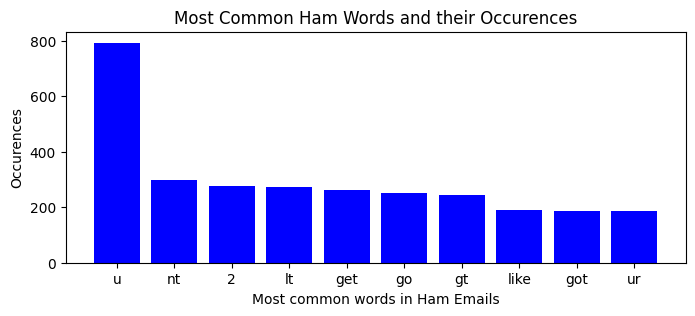

In [21]:
ham_emails = data[data['result']=='ham']['transform']
ham_words = ''.join(ham_emails).split()
ham_word_count = Counter(ham_words)
most_common_words = ham_word_count.most_common(10)
for word, count in most_common_words:
    print(f'{word}: {count} times')
get_words = lambda x: [word[0] for word in x]
get_occurences = lambda x: [word[1] for word in x]
words = get_words(most_common_words)
occurences = get_occurences(most_common_words)
plt.figure(figsize = (8,3))
plt.bar(words, occurences, color = ['Blue'])
plt.xlabel('Most common words in Ham Emails')
plt.ylabel('Occurences')
plt.title("Most Common Ham Words and their Occurences")
plt.show()



# Label Encoding

In [ ]:
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])

,result,emails,Length,num_words,num_sentence,transform
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think go usf life around though
